# Deportation Data Analysis  
*Using ICE Deportation Records (2008–Present)*

This notebook demonstrates loading, cleaning, and analyzing deportation data across multiple CSV files.  
We extract key fields, calculate ages at deportation, and visualize trends by year, gender, and state.

---

### Imports and Setup

In [1]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import plotly.express as px

### Configuration

In [2]:

csv_folder_path = '/Users/sergio/ICE PROJECT/deportation_csvs'

birth_year_candidates = ['Birth Year', 'Year of Birth', 'BirthYear', 'DOB', 'Date of Birth']
departed_date_candidates = ['Departed Date', 'Departure Date', 'Date Removed', 'Date']
port_col_candidates = ['Port of Departure', 'Departure Port', 'Port', 'Port Of Departure']
gender_col_candidates = ['Gender', 'Sex', 'GENDER', 'SEX']
birth_country_candidates = ['Country of Birth', 'Birth Country', 'Country', 'Birthplace']

csv_files = glob(os.path.join(csv_folder_path, '*.csv'))

### Utility Functions

In [3]:
def extract_column_from_files(csv_files, column_candidates, new_column_name):
    extracted_dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        df.columns = df.columns.str.strip()
        column = next((col for col in df.columns if col in column_candidates), None)
        if column:
            df = df[[column]].copy()
            df.rename(columns={column: new_column_name}, inplace=True)
            extracted_dfs.append(df)
        else:
            print(f"⚠️ Missing '{new_column_name}' column in file: {file}")
    return pd.concat(extracted_dfs, ignore_index=True)


def extract_state(port):
    try:
        parts = [p.strip() for p in port.split(',')]
        if len(parts) >= 2:
            return parts[-2]
    except:
        return None
    return None


def normalize_gender(g):
    g = str(g).strip().upper()
    if g in ['M', 'MALE']:
        return 'MALE'
    elif g in ['F', 'FEMALE']:
        return 'FEMALE'
    return 'UNKNOWN'


def assign_president(date):
    if pd.isnull(date): return 'Unknown'
    if date < pd.Timestamp('2017-01-20'):
        return 'Obama'
    elif date < pd.Timestamp('2021-01-20'):
        return 'Trump (1st Term)'
    elif date < pd.Timestamp('2025-01-20'):
        return 'Biden'
    else:
        return 'Trump (2nd Term)'


### Deportations by Year and President

/var/folders/g8/dgnjczz93_v6b9_m64cfwbrw0000gn/T/ipykernel_13141/30494765.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/sergio/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


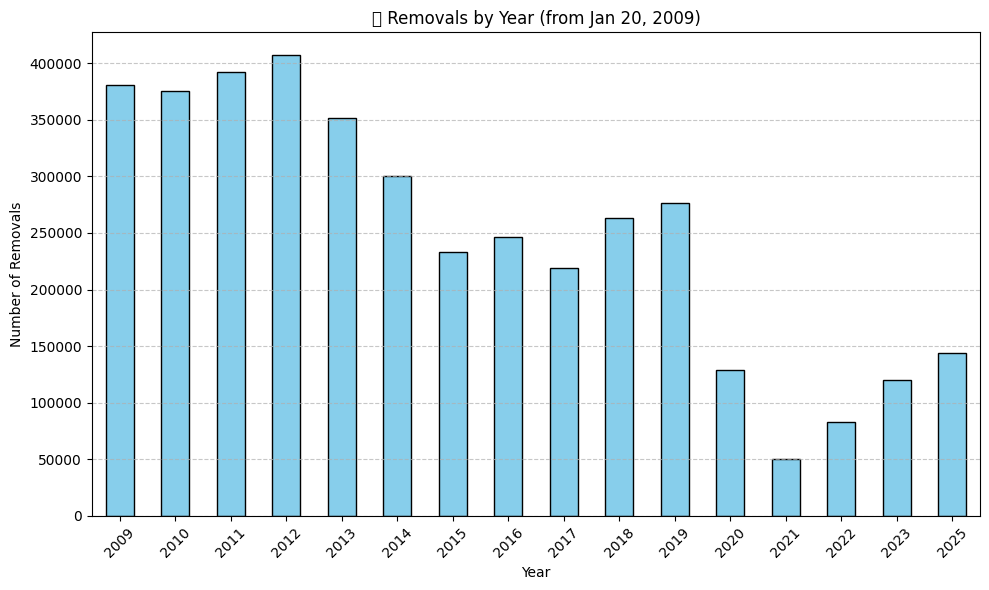

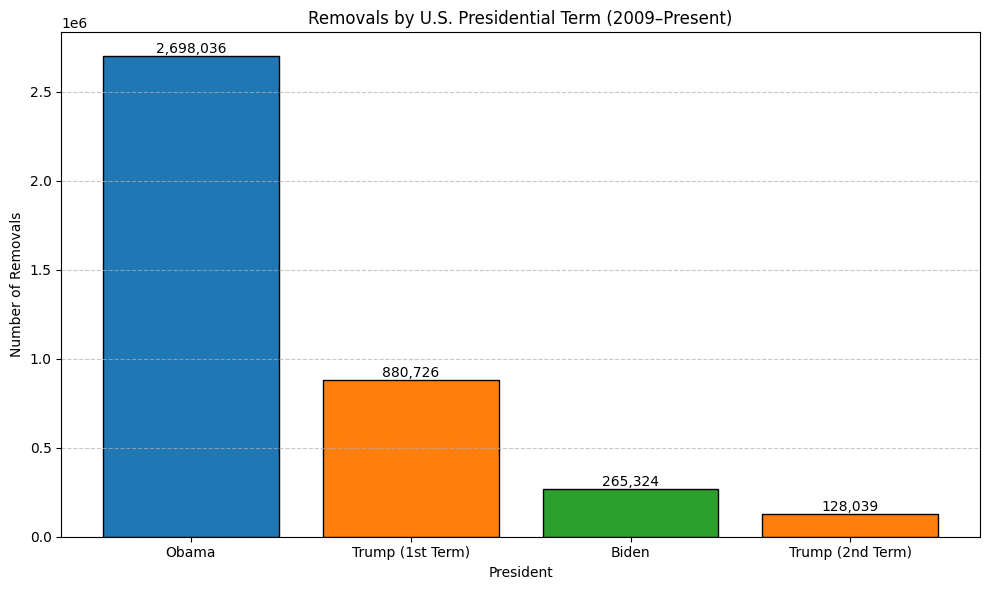

In [4]:
# Load and clean departure dates
df = extract_column_from_files(csv_files, departed_date_candidates, 'Departed Date')
df['Departed Date'] = pd.to_datetime(df['Departed Date'], errors='coerce')
df = df[df['Departed Date'] >= pd.Timestamp('2009-01-20')]
df['Year'] = df['Departed Date'].dt.year
df = df[(df['Year'] >= 2008) & (df['Year'] <= 2025)]

# By Year
year_counts = df['Year'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('📊 Removals by Year (from Jan 20, 2009)')
plt.xlabel('Year')
plt.ylabel('Number of Removals')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# By President
df['President'] = df['Departed Date'].apply(assign_president)
term_counts = df['President'].value_counts().reindex(
    ['Obama', 'Trump (1st Term)', 'Biden', 'Trump (2nd Term)']).fillna(0)

plt.figure(figsize=(10, 6))
bars = plt.bar(term_counts.index, term_counts.values,
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#ff7f0e'], edgecolor='black')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, f'{int(bar.get_height()):,}',
             ha='center', va='bottom')
plt.title('Removals by U.S. Presidential Term (2009–Present)')
plt.xlabel('President')
plt.ylabel('Number of Removals')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Deportations by State

In [5]:
df = extract_column_from_files(csv_files, port_col_candidates, 'Port of Departure')
df['State'] = df['Port of Departure'].apply(extract_state)
df.dropna(subset=['State'], inplace=True)
state_counts = df['State'].value_counts().sort_index()

state_df = state_counts.reset_index()
state_df.columns = ['State', 'Count']

fig = px.choropleth(
    state_df,
    locations='State',
    locationmode='USA-states',
    color='Count',
    scope='usa',
    color_continuous_scale='OrRd',
    title='📍 Deportations by State of Departure'
)
fig.update_layout(geo=dict(bgcolor='rgba(0,0,0,0)'), margin={"r":0,"t":50,"l":0,"b":0})
fig.show()


### Deportations by Gender

/var/folders/g8/dgnjczz93_v6b9_m64cfwbrw0000gn/T/ipykernel_13141/3514584885.py:15: UserWarning:

Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from current font.

/Users/sergio/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from current font.



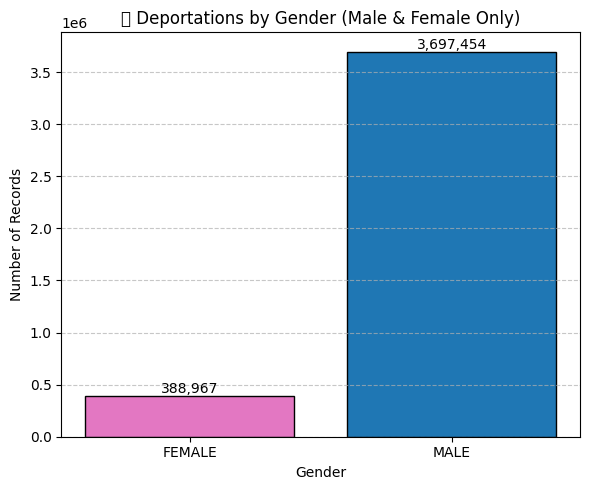

In [6]:
df = extract_column_from_files(csv_files, gender_col_candidates, 'Gender')
df['Gender'] = df['Gender'].apply(normalize_gender)
df = df[df['Gender'].isin(['MALE', 'FEMALE'])]
counts = df['Gender'].value_counts().sort_index()

plt.figure(figsize=(6, 5))
bars = plt.bar(counts.index, counts.values, color=['#e377c2', '#1f77b4'], edgecolor='black')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 500,
             f'{int(bar.get_height()):,}', ha='center', va='bottom')
plt.title('👤 Deportations by Gender (Male & Female Only)')
plt.xlabel('Gender')
plt.ylabel('Number of Records')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Deportations by Country of Birth

/var/folders/g8/dgnjczz93_v6b9_m64cfwbrw0000gn/T/ipykernel_13141/2021325365.py:11: UserWarning:

Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.

/Users/sergio/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.



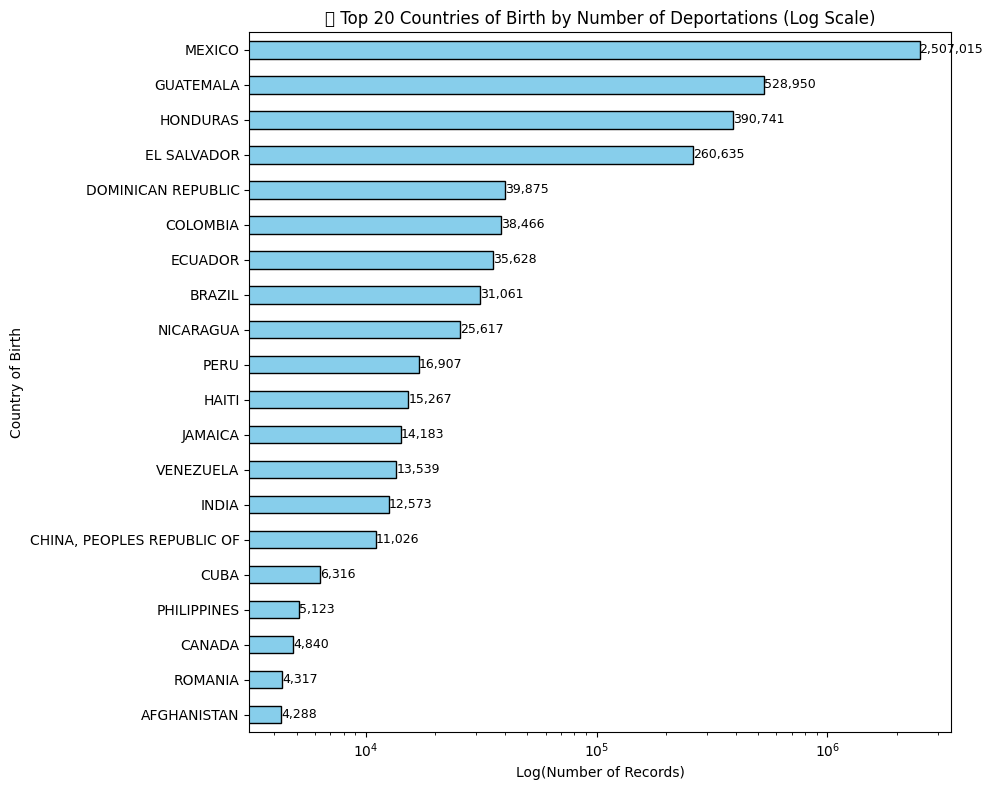

In [7]:
df = extract_column_from_files(csv_files, birth_country_candidates, 'Country of Birth')
country_counts = df['Country of Birth'].value_counts().head(20).sort_values()

plt.figure(figsize=(10, 8))
country_counts.plot(kind='barh', color='skyblue', edgecolor='black', logx=True)
plt.title('🌍 Top 20 Countries of Birth by Number of Deportations (Log Scale)')
plt.xlabel('Log(Number of Records)')
plt.ylabel('Country of Birth')
for i, value in enumerate(country_counts):
    plt.text(value + 1, i, f'{int(value):,}', va='center', fontsize=9)
plt.tight_layout()
plt.show()


### Age at Deportation

/var/folders/g8/dgnjczz93_v6b9_m64cfwbrw0000gn/T/ipykernel_13141/702892354.py:25: UserWarning:

Glyph 128118 (\N{BABY}) missing from current font.

/Users/sergio/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 128118 (\N{BABY}) missing from current font.



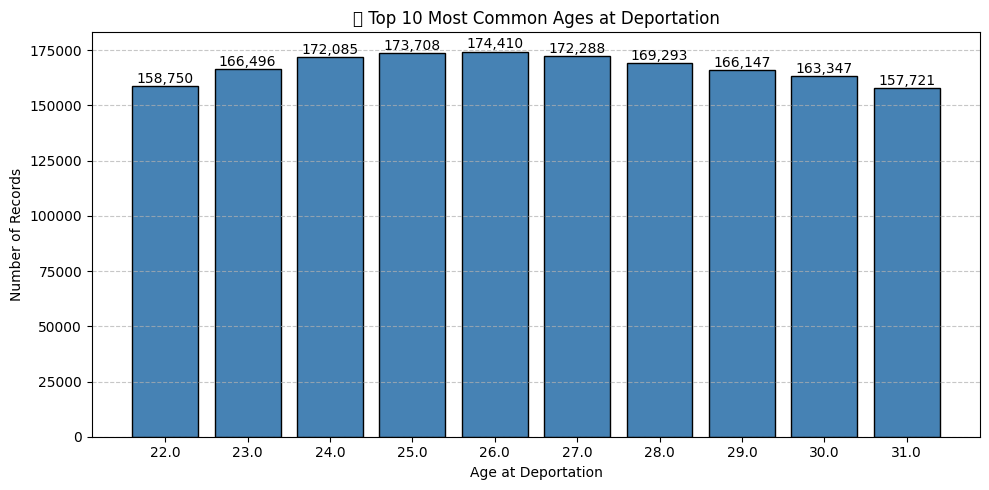

In [8]:
# Extract birth year and departed date
df_birth = extract_column_from_files(csv_files, birth_year_candidates, 'Birth Year')
df_departed = extract_column_from_files(csv_files, departed_date_candidates, 'Departed Date')

# Combine and clean
df = pd.concat([df_birth, df_departed], axis=1)
df['Departed Date'] = pd.to_datetime(df['Departed Date'], errors='coerce')
df['Departed Year'] = df['Departed Date'].dt.year
df['Birth Year'] = pd.to_numeric(df['Birth Year'], errors='coerce')
df.dropna(subset=['Departed Year', 'Birth Year'], inplace=True)
df['Age at Deportation'] = df['Departed Year'] - df['Birth Year']
df = df[(df['Age at Deportation'] >= 1) & (df['Age at Deportation'] <= 120)]

# Plot
plt.figure(figsize=(10, 5))
top_10 = df['Age at Deportation'].value_counts().sort_values(ascending=False).head(10).sort_index()
bars = plt.bar(top_10.index.astype(str), top_10.values, color='steelblue', edgecolor='black')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, f'{int(bar.get_height()):,}', 
             ha='center', va='bottom')
plt.title('👶 Top 10 Most Common Ages at Deportation')
plt.xlabel('Age at Deportation')
plt.ylabel('Number of Records')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()